In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re, string
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import matplotlib.pyplot as plt
from flask import Flask
from flask import request, jsonify

In [3]:
# Read the training data
def read_data(data_path):
    df = pd.read_csv(data_path,sep=';',names=['text','emotions'])
    #print(train_df['emotions'].value_counts())
    #print(train_df.describe())
    return df

# PreProcess the input data
def preProcess_data(input_data):
    # Remove and strip HTML tags if any
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation), '')

# Find the number of words in the train dataset
def num_words():
    train_df['num_words'] = train_df['text'].apply(lambda x:len(str(x).split()))
    
# Encode the output labels to integers
# the labelencoder maps the following categories {0: 'anger', 1: 'fear', 2: 'joy', 3:'love', 4: 'sadness', 5:'surprise'}
def encodeOutputLabels(labels):
    le = LabelEncoder()
    int_labels = le.fit_transform(labels)
    print(int_labels[:10])
    # Convert the intger lables each to binary shape of the given categories
    int_cat_lables = np.asarray(tf.keras.utils.to_categorical(int_labels))
    #print(int_cat_lables[:10])
    return int_cat_lables

In [4]:
# Create the RNN Keras Sequential Model  for Text classification
def create_model():

    # Use the text vectorization layer to normalize, split, and map strings to integers
    # Vocabulary size and number of words in a sequence.
    vocab_size = 10000
    sequence_length = 100
    vectorize_layer = TextVectorization(
        #standardize=preProcess_data,
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=sequence_length)
    # Make a text-only dataset (no labels) and call adapt to build the vocabulary.
    vectorize_layer.adapt(preProcessedTrainData)

    #Create the Sequential model and build the RNN by adding the layers of text vectorization, word embeddings, STM, with hidden and dense layers
    model = tf.keras.Sequential([
        vectorize_layer,
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=64,
            input_length=sequence_length,
            name='embedding'
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(6)
    ])

#     model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#                   optimizer=tf.keras.optimizers.Adam(1e-4),
#                   metrics=['accuracy'])
    return model


In [11]:
# Train the model with train dataset and evaluates for each epoch with validation data
def train_model():
    epochs = 30
    history1 = model.fit(train_dataset.shuffle(2000).batch(128),
              epochs=epochs,
              validation_data=validation_dataset.batch(128),
              verbose=1
              )
    # history2 = model.fit(validation_dataset.shuffle(1000).batch(128),
    #                      epochs=epochs,
    #                      validation_data=validation_dataset.batch(128),
    #                      verbose=1
    #                      )
    return history1

In [12]:
def model_evaluate():
    val_loss, val_accuracy = model.evaluate(preProcessedValData, int_cat_val_lables)
    print("Validation Loss and Accuracy: ", val_loss, val_accuracy)

# Predict the model with the inputs
def model_predict(input_data):
    print('Model prediction is called')
    preProcessedData = preProcess_data(input_data)
    predictions = model.predict(preProcessedData)
    predict_results = predictions.argmax(axis=1)
    print(predict_results)
    labels = {0: 'anger', 1: 'fear', 2:'joy', 3: 'love', 4: 'sadness', 5:'surprise'}
    actual_results = [labels[elem] for elem in predict_results]
    #actual_results = le.inverse_transform(predict_results)
    print(actual_results)
    return actual_results

In [13]:
#Fetch the Training data, Preprocess and encode the labels
train_data_path = '/Users/sreebalaji/sree/GST/emotions_classification/emotion_dataset/train.txt'
train_df = read_data(train_data_path)
train_df = train_df.drop_duplicates(['text'])
print(train_df.describe())
preProcessedTrainData = preProcess_data(train_df['text'])
#print(preProcessedTrainData)
num_words()
print(train_df)
le = LabelEncoder()
int_cat_train_lables = encodeOutputLabels(train_df['emotions'])


                                                     text emotions
count                                               15969    15969
unique                                              15969        6
top     i still have the wtf feeling and regretful fee...      joy
freq                                                    1     5350
                                                    text emotions  num_words
0                                i didnt feel humiliated  sadness          4
1      i can go from feeling so hopeless to so damned...  sadness         21
2       im grabbing a minute to post i feel greedy wrong    anger         10
3      i am ever feeling nostalgic about the fireplac...     love         18
4                                   i am feeling grouchy    anger          4
...                                                  ...      ...        ...
15995  i just had a very brief time in the beanbag an...  sadness         24
15996  i am now turning and i feel pathetic that 

In [14]:
#Fetch the Validation data, Preprocess and encode the labels
val_data_path = '/Users/sreebalaji/sree/GST/emotions_classification/emotion_dataset/val.txt'
val_df = read_data(val_data_path)
val_df = val_df.drop_duplicates(['text'])
print(val_df.describe())
preProcessedValData = preProcess_data(val_df['text'])
print(preProcessedValData)
int_cat_val_lables = encodeOutputLabels(val_df['emotions'])

                                            text emotions
count                                       1998     1998
unique                                      1998        6
top     i feel unimportant and small here lately      joy
freq                                           1      703
tf.Tensor(
[b'im feeling quite sad and sorry for myself but ill snap out of it soon'
 b'i feel like i am still looking at a blank canvas blank pieces of paper'
 b'i feel like a faithful servant' ...
 b'i feel its important to share this info for those that experience the same thing'
 b'i truly feel that if you are passionate enough about something and stay true to yourself you will succeed'
 b'i feel like i just wanna buy any cute make up i see online or even the one'], shape=(1998,), dtype=string)
[4 4 3 0 2 2 2 2 2 4]


In [15]:
# Creates a dataset by slicing the 1Dim of given input tensors ( which are features and labels)
train_dataset = tf.data.Dataset.from_tensor_slices((preProcessedTrainData, int_cat_train_lables))
validation_dataset = tf.data.Dataset.from_tensor_slices((preProcessedValData, int_cat_val_lables))


In [10]:
model = create_model()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])

In [16]:
# Lets Train the model, the RNN model is built only after it sees the train data in training phase.
history = train_model()

Epoch 1/30
125/125 [==============================] - 28s 225ms/step - loss: 1.4870 - categorical_accuracy: 0.4025 - val_loss: 1.1880 - val_categorical_accuracy: 0.5576
Epoch 2/30
125/125 [==============================] - 26s 212ms/step - loss: 0.8150 - categorical_accuracy: 0.6975 - val_loss: 0.6798 - val_categorical_accuracy: 0.7663
Epoch 3/30
125/125 [==============================] - 30s 242ms/step - loss: 0.4169 - categorical_accuracy: 0.8593 - val_loss: 0.4586 - val_categorical_accuracy: 0.8514
Epoch 4/30
125/125 [==============================] - 27s 214ms/step - loss: 0.2235 - categorical_accuracy: 0.9291 - val_loss: 0.4008 - val_categorical_accuracy: 0.8734
Epoch 5/30
125/125 [==============================] - 27s 215ms/step - loss: 0.1481 - categorical_accuracy: 0.9536 - val_loss: 0.4396 - val_categorical_accuracy: 0.8779
Epoch 6/30
125/125 [==============================] - 25s 203ms/step - loss: 0.1146 - categorical_accuracy: 0.9636 - val_loss: 0.4046 - val_categorical_acc

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 100)               0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 64)           640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 751,814
Trainable params: 751,814
Non-trainable params: 0
__________________________________________________

In [18]:
history.history

{'loss': [1.4870243072509766,
  0.8150189518928528,
  0.4169076085090637,
  0.22353526949882507,
  0.14810852706432343,
  0.11458078026771545,
  0.08826181292533875,
  0.06937796622514725,
  0.06112613156437874,
  0.05068317800760269,
  0.0467182993888855,
  0.039302073419094086,
  0.03451371192932129,
  0.030155127868056297,
  0.02173917181789875,
  0.04255218431353569,
  0.024625182151794434,
  0.019246933981776237,
  0.020087910816073418,
  0.026558147743344307,
  0.014212951064109802,
  0.009483927860856056,
  0.013118904083967209,
  0.014732579700648785,
  0.027700789272785187,
  0.015081721358001232,
  0.016089878976345062,
  0.009114313870668411,
  0.009644631296396255,
  0.01882467046380043],
 'categorical_accuracy': [0.40252989530563354,
  0.6974763870239258,
  0.8592898845672607,
  0.9291126728057861,
  0.9535976052284241,
  0.9635543823242188,
  0.9734485745429993,
  0.9787087440490723,
  0.9803995490074158,
  0.983530580997467,
  0.9851587414741516,
  0.9880393147468567,
  

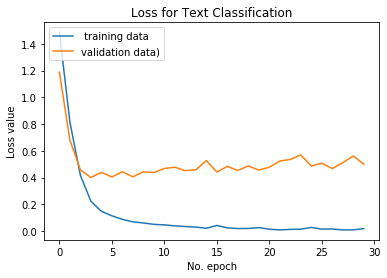

In [19]:
# Plot the Loss and categorical accuracy of train and validation datasets
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

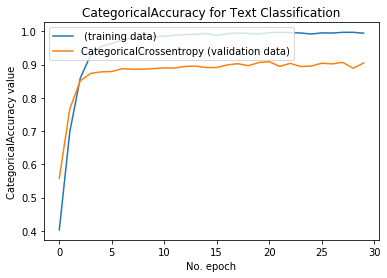

In [20]:
plt.plot(history.history['categorical_accuracy'], label=' (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='CategoricalCrossentropy (validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [22]:
model_predict(['im feeling rather rotten so im not very ambitious right now','im updating my blog because i feel shitty;','i never make her separate from me because i don t ever want her to feel like i m ashamed with her;','i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived','i was feeling a little vain when i did this one','i cant walk into a shop anywhere where i do not feel uncomfortable;'])


Model prediction is called
[4 4 4 2 4 1]
['sadness', 'sadness', 'sadness', 'joy', 'sadness', 'fear']


['sadness', 'sadness', 'sadness', 'joy', 'sadness', 'fear']

In [23]:
model.save('emotion_classifier_model.pb')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: emotion_classifier_model.pb/assets


In [25]:
saved_model = tf.keras.models.load_model('emotion_classifier_model.pb')

In [3]:
res = saved_model.predict(['im feeling rather rotten so im not very ambitious right now','im updating my blog because i feel shitty;','i never make her separate from me because i don t ever want her to feel like i m ashamed with her;','i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived','i was feeling a little vain when i did this one','i cant walk into a shop anywhere where i do not feel uncomfortable;'])
predict_results = res.argmax(axis=1)
print(predict_results)
labels = {0: 'anger', 1: 'fear', 2:'joy', 3: 'love', 4: 'sadness', 5:'surprise'}
actual_results = [labels[elem] for elem in predict_results]
#actual_results = le.inverse_transform(predict_results)
print(actual_results)

NameError: name 'saved_model' is not defined